# A Single Qubit Classifier for 2-dimensions
The problem that the QML paper of my choice aims to tackle is that of data classification. Suppose we have a set of $n$ vectors in $d$-dimensions.<br>
$$X = \{\vec{x}_i\}_{1\leq i \leq n}\quad \vec{x_i} = (x_{i}^{(1)}, x_{i}^{(2)},\ldots, x_{i}^{(d)})$$
And suppose that every vector in a suitable subspace can be labelled with a class (from a finite set of classes).<br>
Our aim is to develop a quantum circuit that is capable of figuring out the label for a given vector.

# The Basic Strategy 
We construct a single-qubit circuit with the gates in it parametrized by some variables, which we then alter using optimization on a training set of labelled data.
## The Parametrization

Their are multiple options to choose from for this task, but given that this implementation incorporates 2-dimensions, we use a method used in this paper: https://journals.aps.org/pra/pdf/10.1103/PhysRevA.106.012411<br>

Each "layer" of our neural-network inspired quantum circuit is:

$$L_l = U(\vec{x}, \vec{\theta}_l)=R_z{(\alpha_l x_1 + \gamma_l)}R_y{(\beta_l x_2 + \delta_l)}$$
where $(x_1, x_2)$ is the vector being classified currently, and $\vec{\theta}_l = (\alpha_l, \beta_l, \gamma_l, \delta_l)$ is our varying parameter-vector for the $l$th layer.

## The Labelling

To label a given data point with a class, we do the following:<br>
1) Assign a single qubit state $\psi_c$ for each class, $c$.
2) Run the circuit for the given data point $\vec{x}$, to obtain the state $\varphi$.
3) Measure the value of: $f(c) = |\langle\psi_c | \varphi\rangle|^2$ for each class, and assign the class $c'$ for which the value of $f(c)$ is the maximum.

# The Overall Picture
If our circuit incorporates $n$ layers then for the vector $\vec{x}$ we get the state:
$$\varphi(\vec{x}, {\Theta}) = U(\vec{x}, \vec{\theta}_n)U(\vec{x}, \vec{\theta}_{n-1})\ldots U(\vec{x}, \vec{\theta}_1)U(\vec{x}, \vec{\theta}_0)|0\rangle$$

Our aim is to optimize $\Theta = (\vec{\theta}_1, \vec{\theta}_2,\ldots ,\vec{\theta}_n)$ such that for each $\vec{x}$, <br>
$\varphi(\vec{x}, \Theta)$ is labelled to $\psi_{c(\vec{x})}$ where $c(\vec{x})$ is the correct class of the vector.<br>

It has been shown in the paper that we can obtain this classifier with arbitrary precision given enough layers.<br>

Essentially, with each gate we are re-uploading the data into our circuit which is only possible classically given the quantum no-cloning theorem.


# The Problem seen visually

We label the points in the 2D subspace $[-1,1]\times[-1, 1]$ as $0/1/2$ based on where they lie.<br>

This has been coded below using matplotlib. <br>
data(samples) returns 2 arrays of size 'sample', one containing the random vectors, the other containing the correct labels.

## Choosing the label states

As the paper suggests, it is optimal to have out label states (here, 3) as far apart as possible on the Bloch sphere. So we choose the states on an equilateral triangle-
$$\begin{align*}
    \text{label 0: }&|0\rangle\\
    \text{label 1: }&\cos\left(\frac{2\pi/3}{2}\right)|0\rangle + \sin\left(\frac{2\pi/3}{2}\right)|1\rangle = \frac{1}{2}|0\rangle + \frac{\sqrt3}{2}|1\rangle\\
    \text{label 2: }&\cos\left(\frac{-2\pi/3}{2}\right)|0\rangle + \sin\left(\frac{-2\pi/3}{2}\right)|1\rangle = \frac{1}{2}|0\rangle- \frac{\sqrt3}{2}|1\rangle
\end{align*}$$

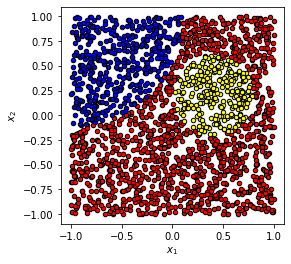

In [1]:
%matplotlib inline
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
import matplotlib.pyplot as plt

np.random.seed(40)

def data(samples):
    center1 = [-1, 1]
    radius1 = 1.1
    center2 = [0.4, 0.2]
    radius2 = 0.4
    pos_vectors, labels = [], []
    for i in range(samples):
        pos = 2 * (np.random.rand(2)) - 1
        label = 0
        if np.linalg.norm(pos - center1) < radius1:
            label = 1
        if np.linalg.norm(pos - center2) < radius2:
            label = 2
        pos_vectors.append(pos)
        labels.append(label)
    return np.array(pos_vectors, requires_grad=False), np.array(labels, requires_grad=False)

def plot_data(x, y, fig=None, ax=None):
    reds = y == 0
    blues = y == 1
    yellows = y == 2
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.scatter(x[yellows, 0], x[yellows, 1], c="yellow", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")


pos_vectors, labels = data(2000)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(pos_vectors, labels, fig, ax)
plt.show()

def density_matrix(state):
    return state * np.conj(state).T

label_0 = [[1], [0]]
label_1 = [[0.5], [np.sqrt(3)/2]]
label_2 = [[0.5], [-np.sqrt(3)/2]]

state_labels = np.array([label_0, label_1, label_2], requires_grad=False)

# The circuit

Given:<br>
an array of the parameter arrays called params, <br>
a data point array x, <br>
and a label y,<br>
the below circuit returns the fidelity of the data point with the chosen label state, for the given params.

## The cost function
Based on the initial discussion, the clear choice for the cost function, for the training data $X$, is:
$$\chi(\Theta) = \frac{\sum\limits_{\vec{x}\in X}(1 - |\langle \psi_{c(\vec{x})} | \varphi(\vec{x}, \Theta)\rangle|^2)}{|X|}$$

In [2]:
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev)
def qcircuit(params, x, y):
    for layer in params:
        qml.RY(layer[0]*x[0] + layer[2], wires=0)
        qml.RZ(layer[1]*x[1] + layer[3], wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0])) # measures fidelity with the state y


def cost(params, x, y, state_labels=None):
    loss = 0.0
    dm_labels = [density_matrix(label) for label in state_labels]
    for i in range(len(x)):
        fidelity = qcircuit(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - fidelity) ** 2
    return loss / len(x) # the average over all data points

# The Metrics
The function get_predictions is used to get the labelling that our parametrized-circuit does for a given dataset.<br>

These predictions can then be used to compute an accuracy_score which is the fraction of correct labels our circuit makes.<br>

iterate_minibatches is used to implement the optimization batch-wise, to avoid stagnation (if optimization step taken point-wise), and cancellation effect (if optimization step taken as an average over the entire data).

unison_shuffled_copies is implemented to shuffle the training data and the lables together after each epoch, to make sure that we optimize the classifier with subsets that keep changing. (suggested in the paper)

In [3]:
def get_predictions(params, x, state_labels):
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []
    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)
        predicted.append(best_fidel)
    return np.array(predicted)

def accuracy_score(y_true, y_pred):
    score = y_true == y_pred
    return score.sum() / len(y_true)

def iterate_minibatches(inputs, targets, batch_size):
    for i in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        batch_indices = slice(i, i + batch_size)
        yield inputs[batch_indices], targets[batch_indices]
    
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

# Training

In [4]:
num_training = 400
num_test = 2000

X_train, y_train = data(num_training)
X_test, y_test = data(num_test)

num_layers = 5
learning_rate = 0.5
epochs = 10
batch_size = 40

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

params = np.random.uniform(size=(num_layers, 4), requires_grad=True)# here taking 4 parameters/layer

predicted_train = get_predictions(params, X_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)
predicted_test = get_predictions(params, X_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)
initial_predictions = predicted_test
loss = cost(params, X_test, y_test, state_labels)

print(f"Epoch 0: Cost on Testing Data = {loss}, Accuracy on Training Data = {accuracy_train}, Accuracy on Testing Data = {accuracy_test}")
print(f"Initial random parameters: {params}")

for i in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)
    
    predicted_train = get_predictions(params, X_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)
    
    print(f"Epoch {i + 1}: Loss on Training Data = {loss}, Current Accuracy on Training Data = {accuracy_train}")
    print(f"Current parameters: \n{params}")
    
    X_train, y_train = unison_shuffled_copies(X_train, y_train)

Epoch 0: Cost on Testing Data = 0.23550945589651903, Accuracy on Training Data = 0.4, Accuracy on Testing Data = 0.4225
Initial random parameters: [[0.92252969 0.68272826 0.65723875 0.64699365]
 [0.05225161 0.29324882 0.22662552 0.74469556]
 [0.60244137 0.66575934 0.476267   0.79872281]
 [0.3610948  0.30372245 0.25949707 0.56314976]
 [0.26216632 0.23809764 0.55257542 0.24166259]]
Epoch 1: Loss on Training Data = 0.19186969120177996, Current Accuracy on Training Data = 0.5325
Current parameters: 
[[ 1.78654267  0.91557902 -0.42228769  1.13259547]
 [ 2.06156112 -0.87801913  0.37723524  2.10208639]
 [ 1.27827919 -1.0330019  -0.31002627  1.09264549]
 [-0.88842567 -1.33966976  0.50666712  0.91936516]
 [-1.07600879 -1.53001629  0.71539456  1.21674926]]
Epoch 2: Loss on Training Data = 0.06297544204041025, Current Accuracy on Training Data = 0.865
Current parameters: 
[[ 1.80684567  1.09015053 -0.33681414  1.81852257]
 [ 1.87994284 -0.89160826  0.55125547  2.49626773]
 [ 1.96654305 -0.6688540

In [5]:
predicted_test = get_predictions(params, X_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)
loss = cost(params, X_test, y_test, state_labels)
print(f"Final Cost on Testing Data = {loss}, Accuracy on Testing Data = {accuracy_test}")
print("Learned parameters-")
for i in range(num_layers):
    print(f"Layer {i}: {params[i]}")

Final Cost on Testing Data = 0.01860087179925811, Accuracy on Testing Data = 0.923
Learned parameters-
Layer 0: [ 3.03947272  1.54069138 -0.23729122  1.09424718]
Layer 1: [ 2.62629045 -1.69254434  0.97515691  2.04565753]
Layer 2: [ 2.24127487 -1.47277278  0.66444553  1.97856809]
Layer 3: [-1.13766772 -1.17568321  0.81872523 -1.04723855]
Layer 4: [-2.30407574  1.8222441  -0.73093596 -0.41387918]


# The Results
After implementing a SQC for 2D data, 3 labels: <br>
Using 10 epochs and 5 layers = 20 parameters, the accuracy on the testing data went from 0.4225 to 0.923.<br>
This can also be seen clearly in the visuals below.

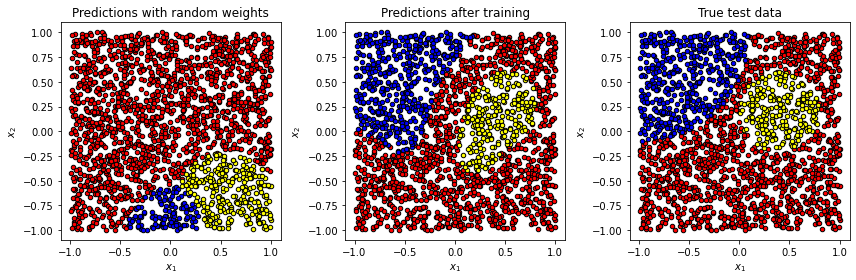

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plot_data(X_test, initial_predictions, fig, axes[0])
plot_data(X_test, predicted_test, fig, axes[1])
plot_data(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

# References
1) https://arxiv.org/abs/1907.02085 : The paper implemented.
2) https://journals.aps.org/pra/pdf/10.1103/PhysRevA.106.012411
3) https://pennylane.ai/qml/demos/tutorial_data_reuploading_classifier.html : This implementation heavily borrows the code for the visuals and the library optimizer from this demo. But the problem considered is a more complex version.